<a href="https://colab.research.google.com/github/sonovman/DL_Term_PJT/blob/main/LSTM%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%A3%BC%EA%B0%80_%EC%98%88%EC%B8%A1%EB%AA%A8%EB%8D%B8_Tutorials_5_CSLee_202211_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. RNN 알고리즘에 관한 튜토리얼의 배경

인공신경망 알고리즘은 데이터를 학습 데이터 세트와 검증 데이터 세트로 나누어 학습 데이터 세트로 신경망의 가중치를 학습시키고 이 결과를 검증 데이터 세트로  확인을 하는 절차를 채택하고 있다. 

그 중 Feed-forward neural networks(FFNets)로 구성된 인공 신경망은 데이터를 입력하면 입력층에서 은닉층까지 연산이 차근차근 진행되고 출력이 나가게 되는데, 이때 입력 데이터는 모든 노드를 지나가면서 연산하게 된다. 따라서 한번 처리된 결과는 다시 입력측으로 되돌아오지 않는다. 그냥 들어오는 데이터 샘플을 독립적으로 학습한다.

따라서 자연어와 같이 단어가 문장 내에서 서로 영향을 미치거나 주가와 같이 시계열 데이터 세트를 FFNets에 넣어 학습하면 입력 데이터 샘플 사이의 영향이나 순서 즉 시간적인 측면이 반영되지 않는다.

이를 극복하고자 고안된 것이 바로 Recurrent Neural Networks (RNN)이다. RNN은 이전에 처리된 은닉층의 연산 결과를 다음 데이터를 입력할 때 다시 같은 은닉층의 입력으로 들어가도록 연결되어 있다. 이런 특성이 RNN이 순서 또는 시간이라는 측면을 고려할 수 있는 특징을 가져다 준다. RNN에서 Recurrent는 '반복되는, 되풀이되는'이라는 의미를 가지고 있는데 이 이름은 은닉층의 결과가 다시 은닉층으로 들어가게 되는 특성을 암시한다. 

특히 특허문서와 같이 자연어로 작성된 정보를 딥러닝으로 처리하기 위해서는 RNN 알고리즘의 이해가 필수적이다고 할 수 있다. 
- (참고) GNN 알고리즘을 적용한 특허 청구항의 분석 알고리즘 역시 기획하고 있으나 본 편에는 담지 않았다.

따라서 **삼성전자 주가를 LSTM 알고리즘으로 예측하는 과정을 Tensorflow/Keras으로 실습**해 봄으로 RNN 알고리즘의 기본 원리를 탐구해보고자 한다. 

주가 예측을 위한 LSTM 모델 설계 및 실습을 위해 "**Deep Learning A-Z™: Hands-On Artificial Neural Networks**" (Udemy) 강의를 참고하였으며, Chris Kuo/Dr. Dataman의 "**[A Technical Guide on RNN/LSTM/GRU for Stock Price Prediction](https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346)**" 블로그 및 [Comparing GRU and LSTM with Stock data Github](https://github.com/minji-OH/Analysis_in_Python/blob/master/Comparing%20GRU%20and%20LSTM%20with%20Stock%20data.ipynb) 를 참고하였다. (원문을 번역한 블로그도 있다. https://diane-space.tistory.com/331 참조)

#2. LSTM 모델을 이용한 주가 예측하기

## Part 1 - 데이터 전처리

### **라이브러리 가져오기**

먼저 필요한 라이브러리를 가져와 정의한다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### **주가 데이터 수집**

주가 데이터를 편리하게 가져올 수 있는 Finance Data Reader [[FinanceData.KR](https://github.com/financedata-org/FinanceDataReader/wiki/)]라는 라이브러리를 설치하고 주가 데이터 샘플을 가져온다.

FinanceDataReader는 한국과 세계 시장의 가격 데이터(주식, 지수, 환율, 선물 등)와 주식 상장 등 금융 데이터를 수집하고 분석하는 오픈소스 라이브러리이다.

In [ ]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**[FinanceDataReader 빠른 사용법 예시시]**

In [ ]:
import FinanceDataReader as fdr

# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
Samsung_df = fdr.DataReader('005930')

# Apple(AAPL), 2017-01-01 ~ Now
Apple_df = fdr.DataReader('AAPL', '2017')

# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
Ford_df = fdr.DataReader('F', '1980-01-01', '2019-12-30')

# AMAZON(AMZN), 2017 (1년)
AMZN_df = fdr.DataReader('AMZN', '2017-01-01', '2019-12-31')

# Samsung(005930), 2000-01-01 ~ 2019-12-31
Samsung_df2 = fdr.DataReader('068270', '2000-01-01', '2019-12-31')

더 자세한 가이드는 [FinanceDataReader_GitHub](https://github.com/financedata-org/FinanceDataReader) 참고

국내 주가 데이터의 경우, 불러온 주가 데이터세트 샘플의 처음 5 행까지의 상단부분의 데이터를 확인하면, 
라이브러리에서 제공하는 데이터는 pd의 DataFram 형식으로 되어 있으며, 날짜(Date)가 행(row)의 Index, 6개의 속성(feature)의 이름이 열(column)의 index로 구성되어 있음을 알 수 있다. 데이터는 기본적으로 Date 를 기준으로 오름차순 정렬되어 있고, 각 데이터 열(column)의 feature는 시가(open),고가(High), 저가(Low), 종가(Close), 거래량(Volume), 전일대비에 대한 등락(Change)으로 이루어져 있다.

In [ ]:
Samsung_df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-08-24,816,823,794,801,427220,NaN
1998-08-25,808,871,808,847,495580,0.057428
1998-08-26,862,917,852,898,1102590,0.060213
1998-08-27,889,892,864,881,473890,-0.018931
1998-08-28,842,862,833,860,551060,-0.023837


pd의 DataFrame 형식의 데이터를 다룰 때 index를 이용하면 프로그램을 효율적이고 쉽게 다룰 수 있다. (참고 : [Pandas-데이터 프레임 Index 가지고 놀기](https://gooopy.tistory.com/92))

In [ ]:
Samsung_df.index

DatetimeIndex(['1998-08-24', '1998-08-25', '1998-08-26', '1998-08-27',
               '1998-08-28', '1998-08-29', '1998-08-31', '1998-09-01',
               '1998-09-02', '1998-09-03',
               ...
               '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10',
               '2022-11-11', '2022-11-14', '2022-11-15', '2022-11-16',
               '2022-11-17', '2022-11-18'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

먼저 불러온 삼성전자 주가 데이터의 인덱스 데이터를 추출해보니, [DatetimeIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html#pandas.DatetimeIndex) 로 지정되어 있다. 따라서 index를 연도, 월, 일로 쪼개 다시 List나 Array로 만드는 등의 조작으로 다양한 방식으로 데이터를 추출하고 다룰 수 있다. (참고 : [데이터 사이언스 스쿨 4.8 시계열 자료 다루기 DatetimeIndex 인덱스 편](https://datascienceschool.net/01%20python/04.08%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EC%9E%90%EB%A3%8C%20%EB%8B%A4%EB%A3%A8%EA%B8%B0.html))     

In [ ]:
Samsung_df.index.year

Int64Index([1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            ...
            2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
           dtype='int64', name='Date', length=6000)

In [ ]:
Samsung_df['Year'] = Samsung_df.index.year
Samsung_df['Year']

Date
1998-08-24    1998
1998-08-25    1998
1998-08-26    1998
1998-08-27    1998
1998-08-28    1998
              ... 
2022-11-14    2022
2022-11-15    2022
2022-11-16    2022
2022-11-17    2022
2022-11-18    2022
Name: Year, Length: 6000, dtype: int64

### **데이터 수집 및 상태 확인**

본 튜토리얼에서는 많은 사람이 가지고 있는 삼성전자 주가 데이터를 가져와 실습하려고 한다. 삼성전자의 주가 종목 코드는 005930 이다.
우리나라 IMF 시대가 끝난 이후 주식 거래가 본격적으로 활발하기 시작한 2016년 이후 데이타만을 가져와 학습에 사용하려고 한다.

In [ ]:
Stock_Code = '005930'              # 삼성전자 종목코드: 005930
Stock_data = fdr.DataReader(Stock_Code, '2016-01-01', '2022-10-31')      

데이터는 pd의 DataFram 형식으로 index가 DatetimeIndex 형식으로 되어 있고, 각 데이터는 시가(open),고가(High), 저가(Low), 종가(Close), 거래량(Volume), 전일대비에 대한 등락(Change)이란 6개의 feature를 갖는다.

In [ ]:
Stock_data.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,25200,25200,24100,24100,306939,-0.043651
2016-01-05,24040,24360,23720,24160,216002,0.002490
2016-01-06,24160,24160,23360,23500,366752,-0.027318
2016-01-07,23320,23660,23020,23260,282388,-0.010213
2016-01-08,23260,23720,23260,23420,257763,0.006879


데이터 샘플의 종목의 "**시가(Open)**" 데이터를 시계열로 시각화하여 전체적인 데이터의 변화동향을 직관해본다. 

이때 Matplotlib에서 제공하는 기본 스타일보다 좀더 세련되고 편리한 그래프를 그리기 위해 패키기 Seaborn을 불러와 사용하기로 한다. Seaborn은 Matplotlib을 기반으로 다양한 색상 테마와 통계용 차트 등의 기능을 추가한 시각화 패키지이다. 기본적인 시각화 기능은 Matplotlib 패키지에 의존하며 통계 기능은 Statsmodels 패키지에 의존한다.

In [ ]:
import seaborn as sns

Text(0, 0.5, 'price')

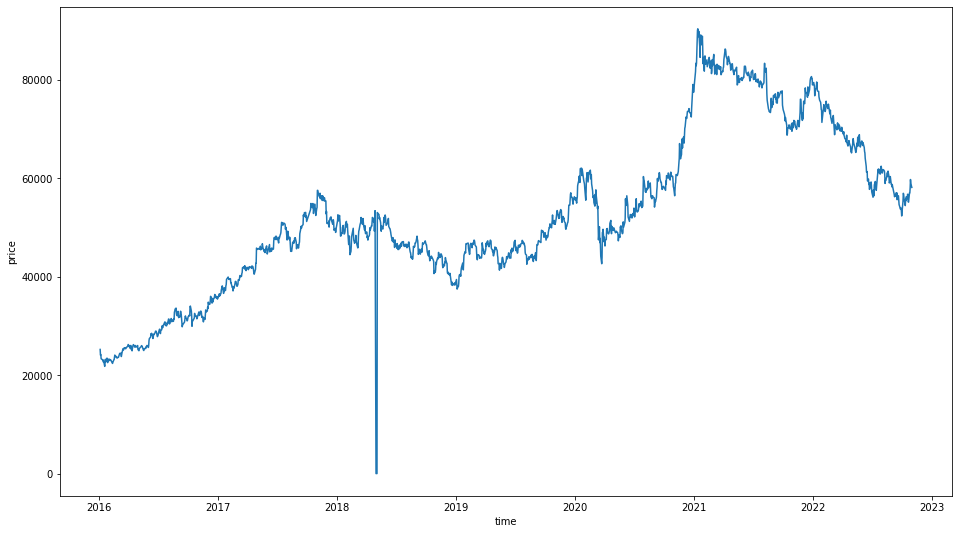

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=Stock_data['Open'], x=Stock_data.index)
plt.xlabel('time')
plt.ylabel('price')

2017년와 2019년 사이에서 종목의 주가 데이터의 특이성 (급락)을 발견하였다. 데이터의 특이성을 보이는 구간을 확인하기 위해 시간 구간을 2구간으로 나누어 확인해보았다. 

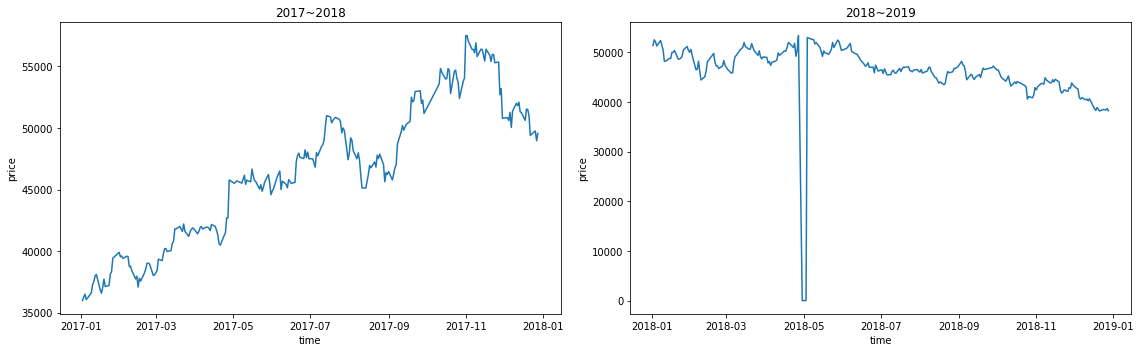

In [ ]:
time_steps = [['2017', '2018'], 
              ['2018', '2019']]

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
for i in range(2):
    ax = axes[i]
    df = Stock_data.loc[(Stock_data.index > time_steps[i][0]) & (Stock_data.index < time_steps[i][1])]
    sns.lineplot(y=df['Open'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

데이터 시각화를 통해 확인 결과 종목의 2018년 5월 주가가 잠시 급격히 하락하였다가 다시 반등한 사실을 확인하였다. 이와 관련된 신문기사(조선일보 입력 2021.11.14)를 찾아 읽어보았다. 그 결과 비정상적인 주가 등락 데이터는 일시적인 현상으로 바로 회복되었고, 최근 상황이 그때와 유사하다는 의견도 있기에 그 구간을 피해 데이터를 다시 샘플링하지 않고 그대로 사용하기로 한다.

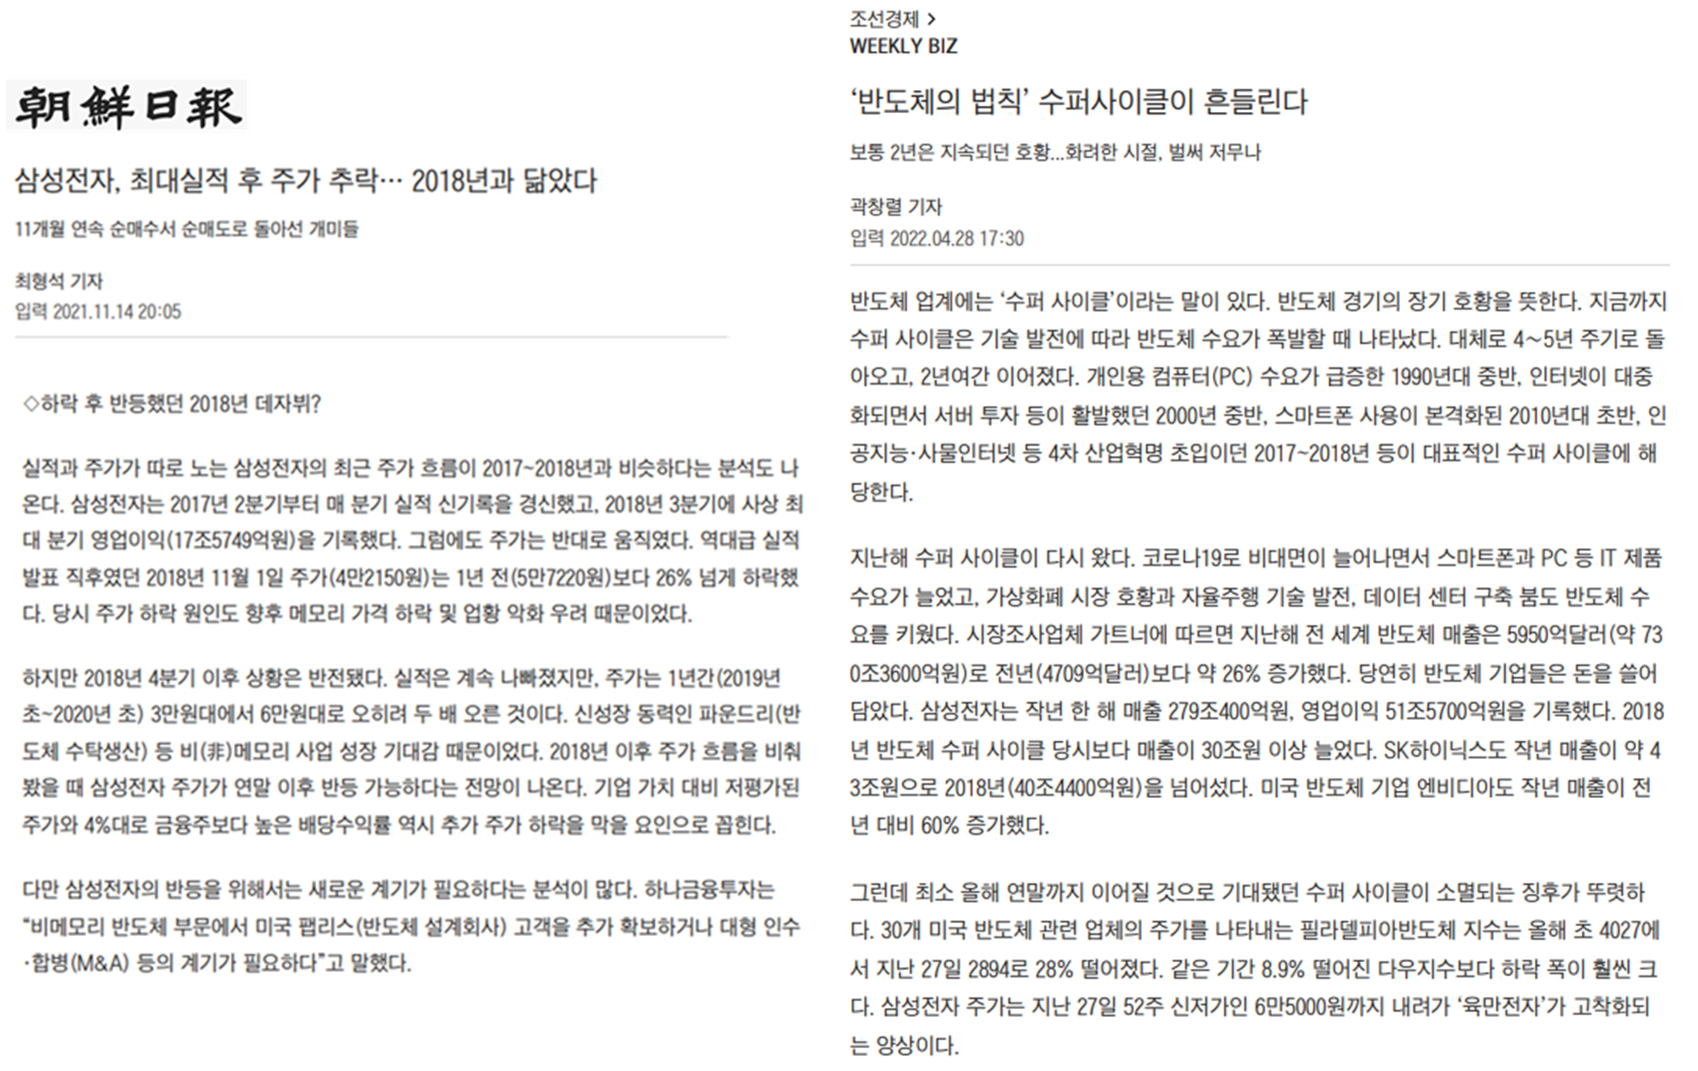

반도체 업황이 주가에 크게 영향을 미치는 삼성전자의 주가의 경우, 종래에는 반도체 업황의 5년 주기설(평균 2~4년마다 가격 상승과 하락을 반복했던 과거 반도체 업황 패턴)에 따른 예측이 지배적이었다. 그러나 최근 그 주기가 1년으로 짧아지거나 사라지고 있다는 분석이 지배적이었다.

이는 과거 반도체 업황 패턴과 4차 산업혁명 이후의 패턴이 달라질 수 있다는 것을 말한다. IT(정보·기술)용 반도체 사용 주기가 1년에서 2년으로, 5~10년인 차량용 반도체 등 아날로그 반도체보다 교체 시기가 짧아지기 때문이라고 한다.

데이터의 분포를 확인해본다. RNN-LSTM 모델에 학습하기 위해서는 이 데이터 그대로 입력값으로 사용하기 어렵고, 정규화하여야 한다.

In [ ]:
Stock_data.describe()

,Open,High,Low,Close,Volume,Change
count,1678.000000,1678.000000,1678.000000,1678.000000,1.678000e+03,1678.000000
mean,52478.827771,52980.336114,51978.420739,52561.197855,1.064340e+07,0.000643
std,16054.048759,16163.274222,15915.699992,15856.093970,1.015033e+07,0.016275
min,0.000000,0.000000,0.000000,22520.000000,0.000000e+00,-0.080357
25%,43750.000000,44150.000000,43212.500000,43800.000000,2.724405e+05,-0.009013
50%,49900.000000,50370.000000,49300.000000,49865.000000,1.040589e+07,0.000000
75%,60900.000000,61400.000000,60375.000000,60900.000000,1.610993e+07,0.009877
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.104706


In [ ]:
Stock_data.isnull()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,False,False,False,False,False,False
2016-01-05,False,False,False,False,False,False
2016-01-06,False,False,False,False,False,False
2016-01-07,False,False,False,False,False,False
2016-01-08,False,False,False,False,False,False
...,...,...,...,...,...,...
2022-10-25,False,False,False,False,False,False
2022-10-26,False,False,False,False,False,False
2022-10-27,False,False,False,False,False,False


아래와 같이 데이터의 결측 여부를 확인하면서 샘플링한 전체 데이터가 총 1,678건임을 확인하였다.

### **학습 데이터와 검증 데이터의 분리**

#### **1) 데이터 분리 정책 수립**

본 튜터리얼에서는 RNN (LSTM) 모델 학습을 위한 i) 학습 데이터는 2016년이후부터 2020년까지의 일일 시가(Open) 데이터를 사용하고, ii) 테스트 데이터는 2021년 부터 2022년 10월 31일까지의 일일 시가(Open) 데이터를 사용하기로 한다.

Udemy 딥러닝 강의에서는 데이터를 먼저 정규화한 후 학습데이터와 검증데이터를 분리하지 말고 데이터를 분리한 후 정규화할 것을 추천하고 있다. 따라서 정규화는 나중에 하기로 한다. 

**A. 2016년~ 2020년까지 데이터 (학습 데이터)**

In [ ]:
Stock_data[:'2020'] # 2016년이후부터 불러온 Staock_data에서 DatetimeIndex 기준 2020년도까지 데이터만 보여준다.

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,25200,25200,24100,24100,306939,-0.043651
2016-01-05,24040,24360,23720,24160,216002,0.002490
2016-01-06,24160,24160,23360,23500,366752,-0.027318
2016-01-07,23320,23660,23020,23260,282388,-0.010213
2016-01-08,23260,23720,23260,23420,257763,0.006879
...,...,...,...,...,...,...
2020-12-23,72400,74000,72300,73900,19411326,0.022130
2020-12-24,74100,78800,74000,77800,32502870,0.052774
2020-12-28,79000,80100,78200,78700,40085044,0.011568


학습데이터는 총 1,227 건이다.

**B. 2021년 1월 1일부터 2022년 10월 31일까지 데이터 (검증 데이터)**

In [ ]:
Stock_data['2021':]  # DatetimeIndex 기준 2021년도 이후 데이터만 보여준다.

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...,...
2022-10-25,57000,58600,57000,57700,17405678,0.003478
2022-10-26,58000,59600,57700,59400,20824967,0.029463
2022-10-27,59700,60100,58900,59500,21756712,0.001684


검증 데이터는 총 451 건이다.

In [ ]:
print("There are "+ str(Stock_data[:'2020'].shape[0]) + " observations in the training data") # Stock_data.shape[0] will display number of rows
print("There are "+ str(Stock_data['2021':].shape[0]) + " observations in the test data")

There are 1227 observations in the training data
There are 451 observations in the test data


본 튜터리얼에서는 삼성전가 주가 데이터 1,678건 중 학습데이터는 1,227건, 검증데이터는 451건을 사용하기로 한다. 따라서 수집된 전체 데이터 중 약 73%는 학습용으로 27%는 검증용으로 사용하게 된다. 

In [ ]:
display(Stock_data['2016':'2020'].shape[0]/Stock_data.shape[0])

0.731227651966627

In [ ]:
display(Stock_data['2021':].shape[0]/Stock_data.shape[0])

0.2687723480333731

#### **2) 학습데이터 및 검증 데이터 세트 만들기 (데이터 세트트 분리 생성)**

학습 등에 사용할 데이터의 feature는 Open(시가)만 사용하기로 한다.

In [ ]:
ts_train = Stock_data[:'2020'].iloc[:,0:1].values   # Stock_data의 DatetimeIndex가 2020년까지의 데이터에서 모든 행과 0번째 열의 값만 선택. 즉 Open(시가)만 선택하여 반환 
ts_test = Stock_data['2021':].iloc[:,0:1].values

In [ ]:
ts_train_len = len(ts_train)
ts_test_len = len(ts_test)

In [ ]:
ts_train_len

1227

In [ ]:
ts_test_len

451

In [ ]:
ts_train  # numpy.ndarray로 변환됨

array([[25200],
       [24040],
       [24160],
       ...,
       [79000],
       [78800],
       [77400]])

In [ ]:
ts_test[:10] # 10개 데이터만 확인

array([[81000],
       [81600],
       [83300],
       [82800],
       [83300],
       [90000],
       [90300],
       [89800],
       [88700],
       [89800]])

### **RNN 학습데이터 및 학습 모델 구조 원리**

* 참고 [A Technical Guide on RNN/LSTM/GRU for Stock Price Prediction](https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346)

##### **1) RNN 모델 구조**

RNN 모델링할 때 처음 만나는 장벽이 RNN 모델에 적합한 입력 데이터 구조를 만들어 주는 것이다. 주가를 예측하는 데이터 구조로 크게 두가지가 있다. 하나는 Many to Many 구조이고 다른 하나는 Many to one 구조이다.

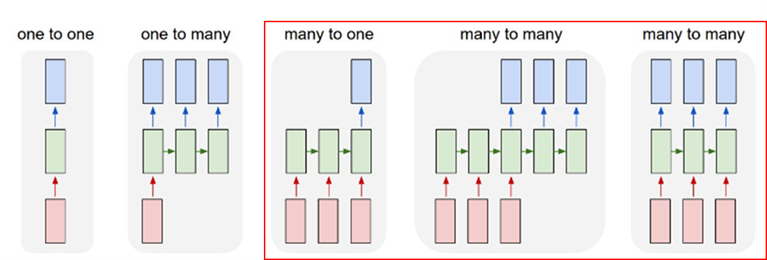

##### **2) Many to Many Structure**

RNN을 설계할 때, 다음 (t+1)에서의 **복수의 n개의 time-step**의 데이터를 예측하기 위해 n개의 입력 time-step으로 훈련하는 아키텍처를 말한다. 예를 들어 입력값이 3개의 time step의 시퀀스 데이터일 때, 예측되는 출력값이 그 다음의 세(3)개의 time step 데이터인 경우이다. 

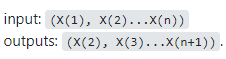

**A. Many to Many 모델 구조 (예시)**

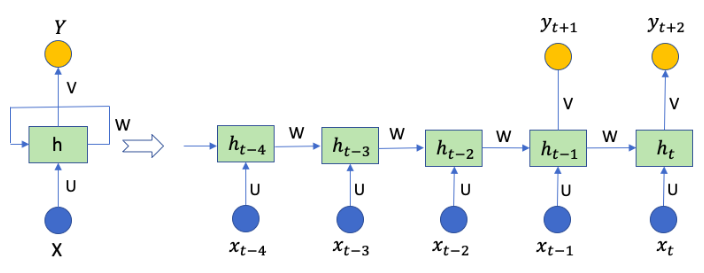

위 그림의 예시에서는 X_train의 각 샘플 (행)에 5개의 입력 $x_{t-4}$, $x_{t-3}$, $x_{t-2}$, $x_{t-1}$, $x_t$ 과 2개의 출력 $y_{t+1}$, $y_{t+2}$을 갖는다. 그래서 다이어그램은 5개의 입력 타임 스텝(Time steps)과 두 개의 출력 타임 스텝(Time steps)을 가진다고 말한다. 그림의 네트워크는 같은 은닉층이 5 번 돌아가는데, 이는 5개의 입력 time steps이 있기 때문이다.

**B. Many to Many 모델의 데이터 구조 (예시)**

아래 그림의 예시는 5일 동안의 주가 데이터 5개로 다음 2일 동안의 주가 데이터 2개를 예측하는 구조를 나타낸다. 입력하는 데이터 샘플 측면에서 볼 때, 5개의 데이터 포인트로 다중 입력하여 2개의 데이터 포인트로 다중 출력한다. 이러한 구조를 many-to-many 구조라 한다.

아래 그림은 종가(Close)를 feature로 하는 1차원의 시계열 데이터 5개 (빨간 window)를 한 타임씩 시리즈로 이동하여 샘플을 만든 것이다.

그림에서는 각 샘플은 5개의 입력과 2개의 출력을 가지며, 각 샘플의 입력이 Time steps이다. 타임 스텝(time steps)을 과거 몇개의 데이터를 기반으로 학습할지를 결정하는 윈도우(windows)라고도 한다. 

여기서는 매 Time step마다 종가라는 하나의 feature를 가지고 있으나, feature는 시가, 종가, 등락폭 등과 같이 여러 개가 될 수도 있다. 예를 들어 "Adj. Close"와 "Open" 가격을 매 time step마다 함께 모델링 한다면, 두 개의 features가 있는 것이다. 그림에서는 "Adj.Close"만 모델링 하였기에 feature 수가 하나(1)이다.

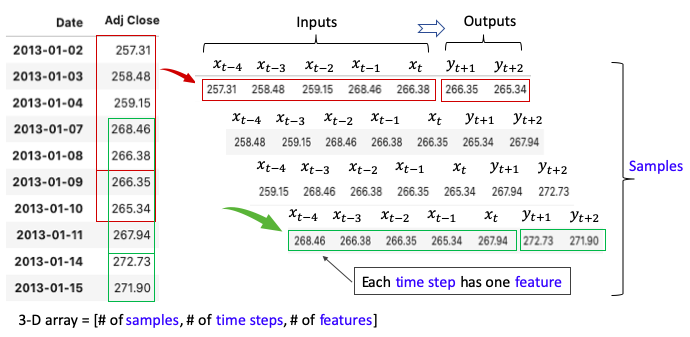

(그림 출처) https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346

##### **3) Many to One Structure**

RNN을 설계할 때, 다음 (t+1)에서의 **1개의 time-step**을 예측하기 위해 n개의 입력 time-step으로 훈련하는 아키텍처를 말한다. 예를 들어 입력값이 3개의 time step의 시퀀스 데이터일 때, 예측되는 출력값이 그 다음 하나의 출력인 경우이다. 

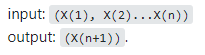

**A. Many to One 모델 구조 (예시)**

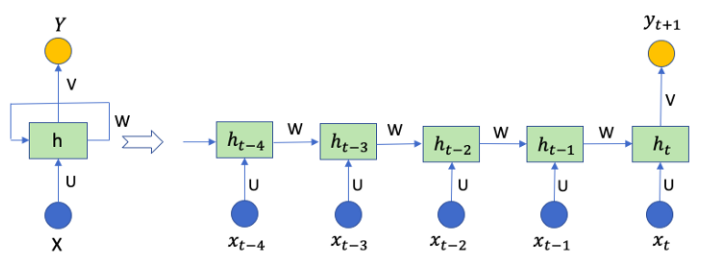

**B. Many to One 모델의 데이터 구조 (예시)**

이 구조로 입력데이터를 설계한다는 것은 과거 ($t-i$)일 동안의 주식 가격 $x_{t-i}$을 이용해서 **미래 하루(1일) 마다** 주식 가격 $y_{t+1}$을 예측하는 것을 의미한다. 

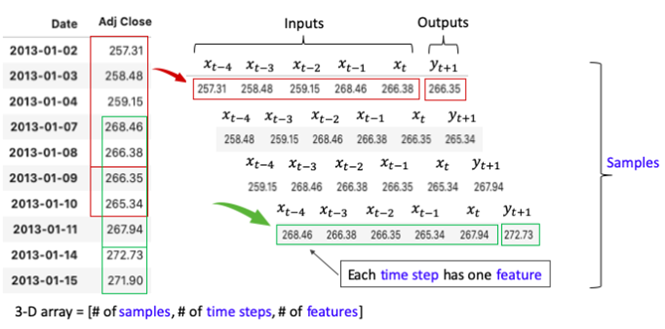

**C. 3차원 텐서 입력데이터**

케라스(Keras)로 RNN 층을 만든다면, RNN 층은 (batch_size, timesteps, input_dim) 크기의 3D 텐서를 입력으로 받는다.

따라서 데이터를 3차원으로 재구성해주어야 하며, 입력데이터는 i) Sample(Data size), ii) Time steps (과거 몇개 데이터를 볼 것인지), iii) Feature (X의 변수개수,차원)요소로 구성된다.

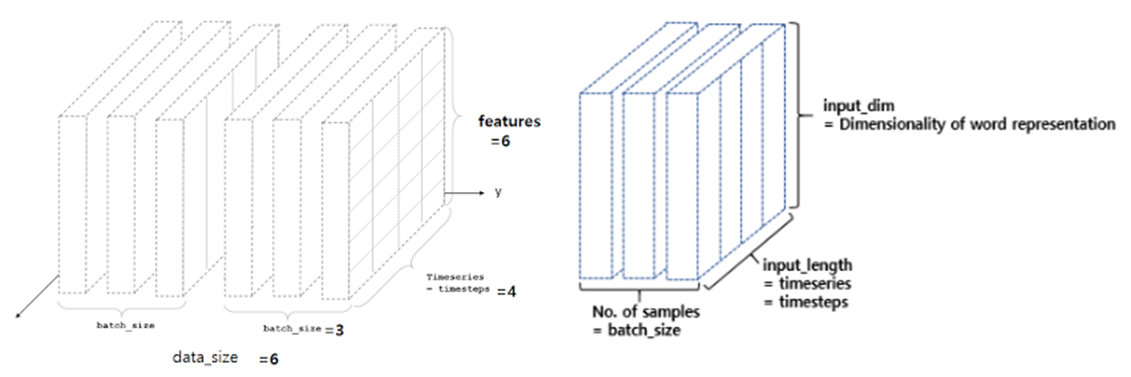

좌측 그림의 블록은 아래와 같은 특성의 3D 텐서 구조를 나타낸다

*   feature (X 변수 개수) = 6
*   time step (과거 며칠까지 값을 반영할 것인지) = 4, 
*   sample (Data size) = 6

### **학습 데이터의 Feature Scaling**

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 데이터를 스케일링(Scaling)한다. 

정규화가 표준화와 다른 가장 큰 특징은 모든 데이터가 0 ~ 1 사이의 값을 가진다는 것이다. 즉, 최대값은 1, 최소값은 0으로 데이터의 범위를 조정된다.

따라서 **활성화 함수로 sigmoid 함수를 사용한 경우 표준화(Standardization)보다는 정규화(Normalization)가 바람직하다.**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
ts_traint_scaled = sc.fit_transform(ts_train)

df_list1 = pd.DataFrame(ts_traint_scaled)
df_list1.describe()

,0
count,1227.000000
mean,0.569943
std,0.135033
min,0.000000
25%,0.504430
50%,0.587342
75%,0.647975
max,1.000000


### **Time steps (윈도우) 결정**

1) **time_steps** :  the input time steps

2) **for_periods** : the output time steps
- for_periods > 1 이면, Many to Many
- for_periods = 1 이면, Many to One 

입력 타임 스텝(Input time steps)은 한번에 입력할 데이터 샘플의 갯수를 말한다.즉, 기준시점으로부터 과거 얼마나 많은 데이터를 가지고 학습할 것인지를 의미한다. 너무 작지 않는 데이터 수를 선택하는 것이 바람직하다. 주가의 시간공간에서 미치는 영향을 생각하여 튜터리얼에서는 60 개이상, 바람직하게는 100개를 선택해보았다.

타입스텝은 너무 작지 않는 데이터 수를 선택하는 것이 바람직하다. 주가의 시간공간에서 미치는 영향을 생각하여 튜터리얼에서는 한 샘플당 60 개의 입력 데이터를 선택해보았다. 즉 학습에 활용할 데이터는 기준시점으로부터 60개의 과거 데이터이다.

In [ ]:
time_steps = input("Input time steps ?")

Input time steps ?60


출력 타임 스텝(Out time steps)은 한번에 출력될 데이터 샘플의 갯수를 말한다. 즉, 기준시점으로부터 다음 얼마나 많은 데이터를 예측할 지를 의미한다. 

현실적으로 매일 다음 날의 주가를 예측하는 것은 그리 도움이 되지 않을 수 있다. 그러나 우선 알고리즘의 성능을 비교해보고 다시 설정하기로 한다.

출력 타입스텝을 1개로 정하면 **many-to-one** 구조가 되고, 출력 타입스텝을 두(2)개 이상으로 정하면 **many-to-many** 구조가 된다.

본 튜터리얼에서는 출력 타입스텝을 2개로 정하기로 한다. 

In [ ]:
for_periods = input("Output time steps ?")

Output time steps ?2


### **학습 데이터 샘플 생성**

앞에서 입력 타임 스텝(time steps)을 결정하였다면, 그 입력 타임 스텝(time steps)만큼 과거 데이터를 기억하여 학습한다는 것을 의미한다. 

입력 타임 스텝(time steps)을 60개로 잡았다면, 현재 관측 시점을 T 라고 할 때, T에서의 데이터는 60번째부터 시작하게 된다. 따라서 예를 들어 학습데이터가 1,678 개라고 하면, 데이터 생성은 학습 데이터의 60번째 부터 시작하여 1,678 개에 이를 때까지 한번 씩 시간 순서대로 미끌어져 가며 데이터를 60개씩 시리즈로 만든다. 즉 학습에 사용할 데이터는 하나의 데이터 샘플 당 60개의 데이터가 된다. 

따라서 반복문 For 문을 이용하여 주가 관측 시점 변수 i를 60번째부터 시작하여 데이터 하나씩 시간 경과에 따라 우측으로 슬라이딩하면서 학습 데이터 개수만큼 학습데이터 샘플을 만든다. 

첫 60개 데이터 샘플은 한 데이터씩 이동하면서 다음의 데이터 세트가 된다. 즉, 첫 데이터 샘플에서 두 번째 데이터는 다음의 60개 데이터 샘플의 첫 번째 데이터가 된다. 이렇게 시간의 경과에 따라 60개씩 학습데이터 세트가 생성되어 간다.

아래 의사코드(psuedo code)와 데이터 구조설계의 그림은 출력 타입스텝을 1로 할 때, 과거 60개 데이터로 학습하여 미래 하루 데이터를 예측하는 Many-to-one 구조의 예이다.

for i in range(60, 1227): 
> - i = 60 부터 (학습데이터 개수 1227 -1개)일 때까지 한 데이터 씩 반복

  X_train.append(ts_traint_scaled[i-60:i, 0]) 
> - T-60부터 학습 데이터 시간 순서대로 하나 씩 추가 생성
> - 초기화된 X_train에 training_set로부터 T시점에서 매 i마다 추가할 학습데이터는 i- 60 = 0 부터, so 이전 데이터 0~59 행, 0열 데이터

  y_train.append(ts_traint_scaled[i, 0])
> - T+1부터 결과 데이터 시간 순서대로 하나 씩 추가 생성  
> - 초기화된 y_train에 training_set_scaled로부터 T시점에서 매 i마다 추가할 학습결과는 60행부터~, 

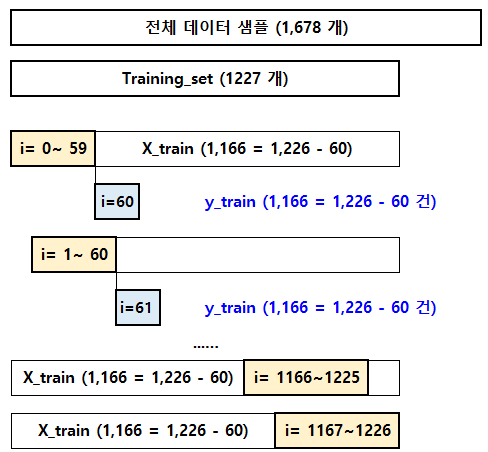

아래 코드에서는 출력 타임 스텝을 for_periods 변수로 지정하여 사용자의 선택에 따라 many-to-one 구조 또는 many-to-many 구조를 선택할 수 있도록 자유도를 두었다.

In [ ]:
# create training data of s samples and t time steps 

X_train = [] 
y_train = [] 
y_train_stacked = [] 

for i in range(int(time_steps), int(ts_train_len) - 1): 
  X_train.append(ts_traint_scaled[i-int(time_steps):i,0])
  y_train.append(ts_traint_scaled[i:i+int(for_periods),0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train

array([[0.31898734, 0.3043038 , 0.30582278, ..., 0.32759494, 0.33164557,
        0.33063291],
       [0.3043038 , 0.30582278, 0.29518987, ..., 0.33164557, 0.33063291,
        0.32886076],
       [0.30582278, 0.29518987, 0.29443038, ..., 0.33063291, 0.32886076,
        0.32379747],
       ...,
       [0.73037975, 0.73797468, 0.73797468, ..., 0.92531646, 0.91772152,
        0.9164557 ],
       [0.73797468, 0.73797468, 0.7278481 , ..., 0.91772152, 0.9164557 ,
        0.93797468],
       [0.73797468, 0.7278481 , 0.75189873, ..., 0.9164557 , 0.93797468,
        1.        ]])

In [ ]:
display(X_train.ndim)
display(X_train.shape)

2

(1166, 60)

In [ ]:
y_train

array([[0.32886076, 0.32379747],
       [0.32379747, 0.32886076],
       [0.32886076, 0.32126582],
       ...,
       [0.93797468, 1.        ],
       [1.        , 0.99746835],
       [0.99746835, 0.97974684]])

### **Reshaping X_train for efficient modelling (데이터 차원 맞추기)**

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
display(X_train.ndim)
display(X_train.shape)

3

(1166, 60, 1)

Keras에서 RNN을 구축할 때 요구하는 입력값의 형식을 보면 3가지 데이터 차원을 요구한다. 그러나 현재 X_train 데이터는 1120 X 100 2차원 데이터이다. 따라서 데이터 변경 없이 reshape() 사용하여 학습데이터 feture 차원을 추가한다.

**inputs: A 3D tensor, with shape [batch, timesteps, feature]**
- batch size : 배치사이즈는 실습에서는 관측값의 데이터 갯수 모두 사용 1198개
- timesteps (input): 100 개씩
- feature : 1

예측을 위한 더 필요한 feature 특성 데이터를 한 개 이상 고려하여 차원을 하나 더 추가하여야 한다. 예) 애플주가는 삼성의 주가와 높은 상관관계가 있음

### **검증데이터(test data sample) 생성**

##### **테스트를 위한 데이터 전처리하기**

검증을 위한 입력 데이터는 먼저 분할 전 전체 데이터로 다시 합치고 그 전체 데이터를 가지고 검증 데이터로 만들어야 한다. 이 검증 데이터는 실제 전체 거래 데이터이다.

그 다음으로 전체 데이터에서 검증 데이터를 빼고 다시 입력 타임스텝(time steps)을 뺀 데이터를 검증을 위한 검증용 입력 데이터로 준비한다.

In [ ]:
inputs = pd.concat((Stock_data["Open"][:'2020'], Stock_data["Open"]['2021':]),axis=0).values
inputs = inputs[len(inputs)-len(ts_test) - int(time_steps):]

input data 는 1차원 데이터가 되었으므로, 2차원의 넘파이 array로 reshape 한다.

다음으로 검증 데이터를 스케일링한다. 

주의할 것은, 만약 fit_transform 메서드를 test data에도 적용하면 test data는 새로운 mean값과 variance값으로 스케일링 된다. 그러나 test data의 feature 값들은 이미 train data로 학습된 Scaler()의 parameter를 이용해 스케일 되어야 한다.
따라서 train data로부터 학습된 mean값과 variance값을 test data에 적용하기 위해 transform() 메서드만 사용한다. test data에 fit_transform을 사용하지 않는다.

In [ ]:
inputs = inputs.reshape(-1,1) # 2차원 np.array로 변환
inputs = sc.transform(inputs)

df_list4 = pd.DataFrame(inputs)
df_list4.describe()

,0
count,511.000000
mean,0.910399
std,0.117707
min,0.662025
25%,0.815823
50%,0.926582
75%,1.013924
max,1.143038


##### **검증 데이터 샘플(Test data sample) 생성**

검증 데이터 역시 학습 데이터 생성 때처럼 기준시점부터 time steps 이전의 데이터에서 시작하여 슬라이딩하며 마지막 날까지 검증 데이터를 생성해 나간다. 

예를 들어, time step이 60 개라고 하고, 검증 데이터 세트가 200 개이고 출력 데이터의 time steps (for_periods)이 2개 라고 하면, For문을 사용하여 입력 검증 데이터 세트의 60번째부터 시작하여 258 개(타임스텝 수와 검증데이터 수를 합한 개수에서 출력 데이터의 time steps (for_periods)를 뺀 개수)까지 시간 순서대로 한번씩 슬라딩하며 60개씩 검증 데이터 샘플을 만든다.

그리고 난 후 검증 데이터의 차원을 학습 데이터의 차원과 같이 3차원으로 일치시킨다.

In [ ]:
X_test = []  # 초기화

for i in range(int(time_steps),ts_test_len+int(time_steps)-int(for_periods)):
  X_test.append(inputs[i-int(time_steps):i,0])
  
  # 학습 단계가 아니므로 y_test 생성은 필요하지 않다.

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # X_train 셋과 차원 일치(3차원으로 변경)

### **입력값과 출력값 데이터 생성을 위한 Re-Coding ( 함수 정의를 이용)**

앞에서 살펴본 입력값과 출력값 데이터 생성을 위한 코드를 함수를 정의하여 하나의 함수 안에서 다시 작성해본다.

In [ ]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data (날짜를 인덱스로 하는 주가 데이터)
    output:
      X_train, y_train: 2016년부터 2020년까지 데이터
      X_test: 2021년 이후 데이터
    time_steps: # input 데이터의 time steps
    for_periods: # output 데이터의 time steps
    '''
    # training and test set 만들기 
    ts_train = all_data[:'2020'].iloc[:,0:1].values 
    ts_test = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    # training data의 샘플과 time steps으로 원본 데이터 슬라이싱하기기  
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
        
    # Reshaping X_train for efficient modelling 3차원 텐서로 재구성
    # np.reshape(sample, time steps, features)로 만듬
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test (feature 시가(Open)만 선택 결합)
    inputs = pd.concat((all_data["Open"][:'2020'], all_data["Open"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

학습할 과거 데이터 입력의 윈도우 Time_steps의 개수는 60개 이상을 입력하기로 한다. 본 튜토리얼에서는 먼저 60개로 지정하여 학습 성능을 보고 다시 조정하기로 한다.

In [ ]:
time_steps = input("Input time steps ?")

Input time steps ?60


본 튜토리얼에서는 출력 타입스텝을 2개로 정하여 many-to-many 구조를 채택하기로 한다. 즉 미래 예측할 데이터 출력의 윈도우 Time_steps의 개수를 2개로 결정한다. 그러나 하루나 이틀 후의 주가 데이터는 현실적으로 큰 의미가 없기 때문에 나중에 성능을 보면서 좀더 예측하려는 출력의 타입 스텝을 늘려갈 예정이다.

In [ ]:
for_periods = input("Output time steps ?")

Output time steps ?2


In [ ]:
X_train, y_train, X_test = ts_train_test(Stock_data,int(time_steps),int(for_periods)) # input함수로 입력된 값은 int()로 변환해주어야 함.

In [ ]:
X_train.shape

(1166, 60, 1)

In [ ]:
X_train.shape[0],X_train.shape[1]

(1166, 60)

In [ ]:
X_test.shape[0],X_test.shape[1]

(449, 60)

In [ ]:
X_train_ = np.reshape(X_train, (X_train.shape[0],X_train.shape[1]))

In [ ]:
X_train.shape

(1166, 60, 1)

X_train, Y_train, X_test를 데이터 프레임으로 바꾸고 출력하여 데이터를 확인해본다.

In [ ]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
# 3차원의 X_train을 pd의 2차원의 데이터프레임으로 바꿔서 확인하기

# np의 reshape를 이용, 학습데이터(x_train)의 형태를 바꿔 준다. reshape의 첫 번째 인자는 바꿀 데이터(x_train)를, 두 번째는 어떤 형태로 바꿀지를 넣어준다.
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)

# Convert the 3-D shape of X_test to a data frame so we can see: 
# 3차원의 X_test을 pd의 데이터프레임으로 바꿔서 확인하기기

X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))

print("There are " + str(X_train.shape[0]) + " samples in the training data")

print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1166 samples in the training data
There are 449 samples in the test data


In [ ]:
display(X_train_see)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.318987,0.304304,0.305823,0.295190,0.294430,0.292658,0.290633,0.291899,0.286329,0.288608,...,0.323544,0.322532,0.320759,0.321266,0.323797,0.324810,0.326076,0.327595,0.331646,0.330633
1,0.304304,0.305823,0.295190,0.294430,0.292658,0.290633,0.291899,0.286329,0.288608,0.275443,...,0.322532,0.320759,0.321266,0.323797,0.324810,0.326076,0.327595,0.331646,0.330633,0.328861
2,0.305823,0.295190,0.294430,0.292658,0.290633,0.291899,0.286329,0.288608,0.275443,0.285570,...,0.320759,0.321266,0.323797,0.324810,0.326076,0.327595,0.331646,0.330633,0.328861,0.323797
3,0.295190,0.294430,0.292658,0.290633,0.291899,0.286329,0.288608,0.275443,0.285570,0.293671,...,0.321266,0.323797,0.324810,0.326076,0.327595,0.331646,0.330633,0.328861,0.323797,0.328861
4,0.294430,0.292658,0.290633,0.291899,0.286329,0.288608,0.275443,0.285570,0.293671,0.286835,...,0.323797,0.324810,0.326076,0.327595,0.331646,0.330633,0.328861,0.323797,0.328861,0.321266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,0.739241,0.730380,0.730380,0.737975,0.737975,0.727848,0.751899,0.743038,0.765823,0.759494,...,0.913924,0.912658,0.920253,0.930380,0.931646,0.934177,0.937975,0.929114,0.927848,0.925316
1162,0.730380,0.730380,0.737975,0.737975,0.727848,0.751899,0.743038,0.765823,0.759494,0.772152,...,0.912658,0.920253,0.930380,0.931646,0.934177,0.937975,0.929114,0.927848,0.925316,0.917722
1163,0.730380,0.737975,0.737975,0.727848,0.751899,0.743038,0.765823,0.759494,0.772152,0.772152,...,0.920253,0.930380,0.931646,0.934177,0.937975,0.929114,0.927848,0.925316,0.917722,0.916456
1164,0.737975,0.737975,0.727848,0.751899,0.743038,0.765823,0.759494,0.772152,0.772152,0.768354,...,0.930380,0.931646,0.934177,0.937975,0.929114,0.927848,0.925316,0.917722,0.916456,0.937975


출력 결과에서 볼 수 있듯이 60 개의 시계열의 시리즈 데이터거 하나의 학습 데이터 샘플이 되고 그러한 샘플 데이터 세트가 총 1166개가 생성되었다.

In [ ]:
display(y_train_see)

,0,1
0,0.328861,0.323797
1,0.323797,0.328861
2,0.328861,0.321266
3,0.321266,0.329114
4,0.329114,0.321266
...,...,...
1161,0.917722,0.916456
1162,0.916456,0.937975
1163,0.937975,1.000000
1164,1.000000,0.997468


출력 결과에서 볼 수 있듯이 예측할 주가와 비교할 실제 데이터는 이틀분의 데이터 세트로 총 116개의 데이터 세트가 준비되었다. 

In [ ]:
display(X_test_see)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.751899,0.743038,0.765823,0.759494,0.772152,0.772152,0.768354,0.759494,0.754430,0.763291,...,0.937975,0.929114,0.927848,0.925316,0.917722,0.916456,0.937975,1.000000,0.997468,0.979747
1,0.743038,0.765823,0.759494,0.772152,0.772152,0.768354,0.759494,0.754430,0.763291,0.774684,...,0.929114,0.927848,0.925316,0.917722,0.916456,0.937975,1.000000,0.997468,0.979747,1.025316
2,0.765823,0.759494,0.772152,0.772152,0.768354,0.759494,0.754430,0.763291,0.774684,0.763291,...,0.927848,0.925316,0.917722,0.916456,0.937975,1.000000,0.997468,0.979747,1.025316,1.032911
3,0.759494,0.772152,0.772152,0.768354,0.759494,0.754430,0.763291,0.774684,0.763291,0.764557,...,0.925316,0.917722,0.916456,0.937975,1.000000,0.997468,0.979747,1.025316,1.032911,1.054430
4,0.772152,0.772152,0.768354,0.759494,0.754430,0.763291,0.774684,0.763291,0.764557,0.764557,...,0.917722,0.916456,0.937975,1.000000,0.997468,0.979747,1.025316,1.032911,1.054430,1.048101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,0.782278,0.770886,0.769620,0.775949,0.788608,0.789873,0.772152,0.774684,0.779747,0.781013,...,0.717722,0.707595,0.688608,0.705063,0.701266,0.711392,0.706329,0.717722,0.717722,0.698734
445,0.770886,0.769620,0.775949,0.788608,0.789873,0.772152,0.774684,0.779747,0.781013,0.781013,...,0.707595,0.688608,0.705063,0.701266,0.711392,0.706329,0.717722,0.717722,0.698734,0.697468
446,0.769620,0.775949,0.788608,0.789873,0.772152,0.774684,0.779747,0.781013,0.781013,0.777215,...,0.688608,0.705063,0.701266,0.711392,0.706329,0.717722,0.717722,0.698734,0.697468,0.721519
447,0.775949,0.788608,0.789873,0.772152,0.774684,0.779747,0.781013,0.781013,0.777215,0.767089,...,0.705063,0.701266,0.711392,0.706329,0.717722,0.717722,0.698734,0.697468,0.721519,0.721519


## Part 2 - LSTM 모델 설계 및 학습 작동 이해

개발자를 위한 Keras 공식문서를 참고하여 RNN 구축 방법 참고한다.

[**Developer guides / Working with RNNs**]
- https://keras.io/guides/working_with_rnns/#introduction

**[Keras의 LSTM "Units" (num_units) 란?]**

LSTM에 대해 배울 때, 케라스의 LSTM 계층에서 "units"가 무엇인지 궁금하다. 예를 들어 keras.layer를 사용할 때 LSTM(32)가 "units"이다.

 Each hidden layer has hidden cells, as many as the number of time steps. And further, each hidden cell is made up of multiple hidden units, like in the diagram below. Therefore, the dimensionality of a hidden layer matrix in RNN is (number of time steps, number of hidden units)

**각 은닉층에는 time steps의 개수만큼 은닉 셀(hidden cells)이 있다. 또한, 각각의 은닉 셀(hidden cells)은 아래 그림과 같이 여러 개의 은닉 유닛(hidden units)로 구성되어 있다**. 그러므로, RNN 에서 은닉층 행렬의 차원은 (Time steps의 개수 X 은닉 Units의 개수)가 된다.

https://tung2389.github.io/coding-note/unitslstm

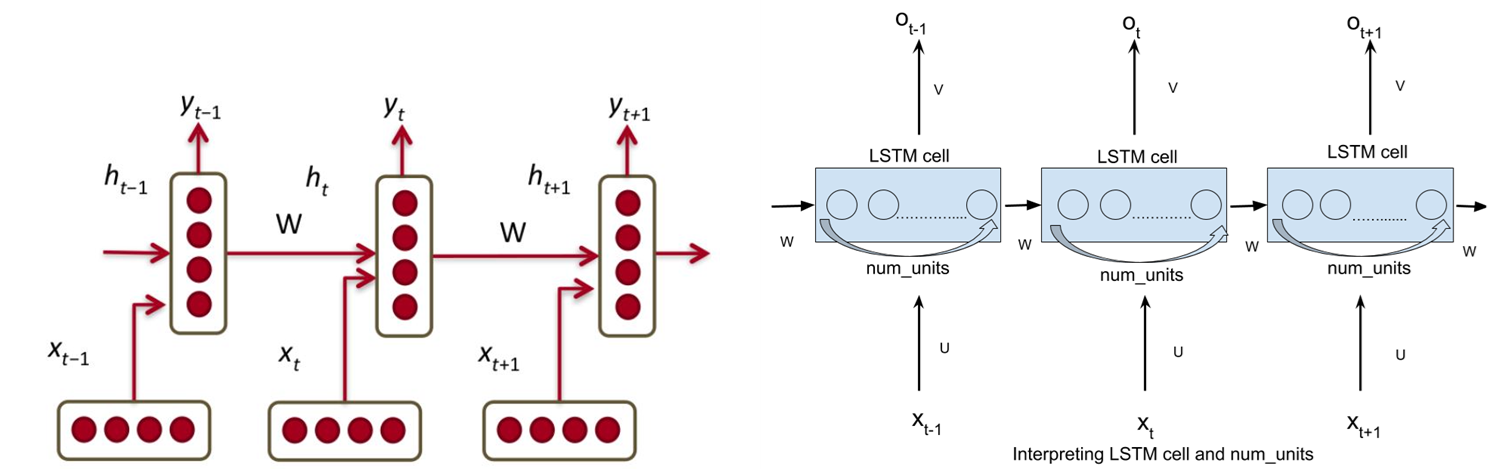

은닉층의 길이 (length of h — no. of hidden units)는 라이브러리마다 서로 다른 표현으로 명명하고 있으나 모두 같은 의미이다.
- Keras — state_size , **units**
- PyTorch — hidden_size
- TensorFlow — **num_units**

또한 Keras Documentation에서 RNN 부분을 읽을때, **cell, unit, h_t, output_t, state_t (keras doc : RNN), previous_output**들은 모두 같은 의미이다. 즉 이들은 모두 RNN계열의 모델들이 output vector를 의미한다. 한 덩어리라고 생각하면 된다. 모두 하나의 vector이다.

반면, **num(#) of units, dimensionality of the output space, h_t의 dimension, state_t의 dimension** (keras doc : RNN), **units** (keras doc : RNN, LSTM, GRU etc), **output_features** (위에 numpy로 구현하는 RNN 예제에서), **RNN(32), LSTM(32), GRU(32) **에서의 32라는 input들은 모두 같은 말이다. 즉 이 용어들은 dimension을 의미한다. 모두 하나의 숫자로 표현될 수 있다.

참고로 output이라는 것은 어떤 layer 까지 고려한지에 따라 달라질 수 있다. 내가 언급한 output이란 keras에서 RNN, LSTM, GRU 등의 한 state를 돌고나서의 출력값들을 의미한다.


<참고> https://taeu.github.io/nlp/deeplearning-nlp-rnn/


[Animated RNN, LSTM and GRU](https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45) 참고



LSTM cell은 3개의 게이트(forget, input, output)로 구성되어있고, 이를 통해서 기존 RNN보다 긴 시퀀스를 학습할 수 있게 된다. 아래 사진은 한개의 cell에 대한 설명이다. 아래 그림은 t로 인덱싱되는 하나의 time step에서 발생하는 수학적 연산을 보여준다. 배치 크기가 1인 3개 입력 크기(녹색)과 2개의 히든 유닛 (빨간색) 크기를 사용한 예시이다. 

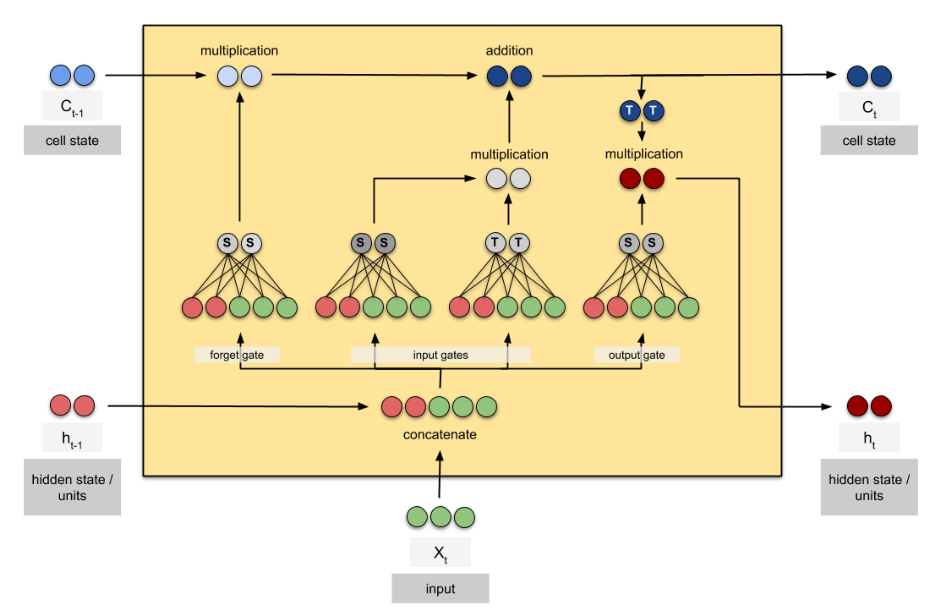

keras LSTM의 input 중 하나인 num_units는 hidden state (output)의 차원이다. 위 사진의 빨간색 동그라미의 개수가 num_units이다. 

따라서 위의 그림은 2개의 units를 가진 하나의 LSTM cell이다. 

그리고 다음 cell이 전 hidden state (units, ht)와 input (xt)를 더하고 세개의 게이트를 지나서, 다음 hidden state (units, ht+1)를 계산한다. 

(= layer의 num_units에 지정해준 개수) 반복되는 LSTM cell의 개수는 전체 time step (t)의 개수와 같다.

입력 데이터의 feature 차원 [$N_x$ X 1]은 은닉층  [ $N_h$ X $N_x$] 과 행렵곱되는 과정에서 사라지고 결국 은닉층의 연산결과의 차원은 (은닉층의 차원이 $N_h$라고 할 때), [ $N_h$ X 1 ] 이 된다. 은닉층의 차원은 보통 관습적으로 32, 64, 128과 같은 32의 배수를 사용한다고 한다고 한다.

은닉층의 차원은 은닉층을 구성하는 뉴런의 수를 의미하며, 모든 과거 정보의 기억을 유지하기 위해서 RNN의 성능을 결정한다. 그러나 이 뉴런의 수를 키우는 것 보다는 더 많은 hidden layer을 쌓는게 효과적이라고 한다.    

일반적으로 다수의 은닉 셀(hidden cell)을 포함한 은닉층(hidden layer)을 여러층을 쌓아서 모델을 만든다. 

LSTM의 첫번째 layer에는 input_size를 넣어줘야하고, 두번째 layer부터는 이전 layer의 output size가 자동으로 input_size가 된다. 일반적으로 성능 향상에 hidden units의 개수를 늘리기보다, 더 많은 hidden layer을 쌓는게 효과적이라고 한다

본 튜터리얼에서는 은닉 unit을 50개로 설정하고, 은닉층을 4개의 층으로 구성하고자 한다. 

첫번째 은닉층은 입력(input)의 크기를 지정하나, 그 다음의 은닉층에서는 첫번째 은닉층의 결과가 입력으로 들어오므로 입력의 크기 지정이 불필요하다.

은닉층을 적층하여 연결하는 방법은 은닉층의 return_sequences 인수값을 True로 설정하고 Full Connected 층으로 연결할 때는 default 값인 false로 한다.

## **Part 3 - LSTM 모델 설계 및 학습 실행 (Udemy 강의에 따른 설계)**

### **1) LSTM 모델의 설계#1 (Udemy)**

첫번째 설계는 Udemy 강의에서 가르쳐준 방법대로 모델을 설계해본다.

### Importing the Keras libraries and packages

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

### Initialising the RNN

본 튜토리얼에서는 주가가 연속된 데이터 값이란 점에서 착안하여 회귀분석으로 Sequential Layer를 정의하였다.

In [ ]:
regressor = Sequential()  # 연속된 데이터 값에 대한 회귀분석으로 Sequential Layer 정의

### Adding the **1st LSTM layer** and some Dropout regularisation

Keras API reference 에서 "LSTM layer" 편을 참고하여 설정한다. 본 튜터리얼에서는 4개의 LSTM 층으로 모델을 구축하였다.

[**Keras API reference / Layers API / Recurrent layers / LSTM layer**] 
-  https://keras.io/api/layers/recurrent_layers/lstm/

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1))) # shape[0]은 메모리만 확보하여 나중에 훈련된 입력값으로 자동 처리
regressor.add(Dropout(0.2))

### Adding the **2nd LSTM layer** and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True)) # 메모리층만 추가 (입력층 지정 불필필요)
regressor.add(Dropout(0.2))

### Adding the **3rd LSTM layer** and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding the **4th LSTM layer** and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50)) # 마지막층이므로 return_sequences 값은 default 값인 false
regressor.add(Dropout(0.2))

### Adding **the output layer**

Keras API reference 에서 "Dense layer" 편을 참고하여 Full connection Dense 층을 설정한다.

[ **Keras API reference / Layers API / Core layers / Dense layer**] 
- https://keras.io/api/layers/core_layers/dense/ 

In [ ]:
regressor.add(Dense(units = 1))   # 회귀분석의 마지막층인 Full connection Dense층 추가, 출력 뉴런수는 1개, 1개 차원 특성값만 가지는 출력 예측

### Compiling the RNN

모델을 훈련하기 위해서는 모델 컴파일을 통해 loss function, an optimizer 등을 지정해주어야 한다. 본 튜터리얼에서는 loss function는 제곱오차법, 최적화는 Adams 기법을 사용한다.

https://keras.io/guides/training_with_built_in_methods/

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### **2) LSTM 모델#1 (Udemy)의 학습**

### Fitting the RNN to the Training set

본 튜터리얼에서는 에포크 150번, 배치 크기는 32개 주가 데이터로 하였다. 학습결과를 보고 다시 수정하기로 한다.

In [ ]:
regressor.fit(X_train, y_train, epochs = 150, batch_size = 32) # 배치크기는 32개 주가 데이터로 지정

Epoch 1/150
37/37 [==============================] - 10s 16ms/step - loss: 0.0415
Epoch 2/150
37/37 [==============================] - 1s 14ms/step - loss: 0.0078
Epoch 3/150
37/37 [==============================] - 1s 14ms/step - loss: 0.0067
Epoch 4/150
37/37 [==============================] - 1s 15ms/step - loss: 0.0058
Epoch 5/150
37/37 [==============================] - 1s 16ms/step - loss: 0.0058
Epoch 6/150
37/37 [==============================] - 1s 15ms/step - loss: 0.0053
Epoch 7/150
37/37 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 8/150
37/37 [==============================] - 1s 14ms/step - loss: 0.0051
Epoch 9/150
37/37 [==============================] - 1s 15ms/step - loss: 0.0057
Epoch 10/150
37/37 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 11/150
37/37 [==============================] - 1s 14ms/step - loss: 0.0048
Epoch 12/150
37/37 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 13/150
37/37 [====

In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

### **3) 학습된 LSTM 모델을 이용한 예측과 결과 시각화 (Udemy)**

### Getting the real stock price 

In [ ]:
Stock_data # 2016년이후 데이터

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,25200,25200,24100,24100,306939,-0.043651
2016-01-05,24040,24360,23720,24160,216002,0.002490
2016-01-06,24160,24160,23360,23500,366752,-0.027318
2016-01-07,23320,23660,23020,23260,282388,-0.010213
2016-01-08,23260,23720,23260,23420,257763,0.006879
...,...,...,...,...,...,...
2022-10-25,57000,58600,57000,57700,17405678,0.003478
2022-10-26,58000,59600,57700,59400,20824967,0.029463
2022-10-27,59700,60100,58900,59500,21756712,0.001684


앞에서 데이터 샘플에서 학습데이터와 검증데이터를 분할하였기 때문에 분할전 데이터 샘플이 실제 거래 데이터 전체가 된다.

In [ ]:
da_train_df = Stock_data[:'2020'].iloc[:,0:1] 

In [ ]:
da_train_df

,Open
Date,
2016-01-04,25200
2016-01-05,24040
2016-01-06,24160
2016-01-07,23320
2016-01-08,23260
...,...
2020-12-23,72400
2020-12-24,74100
2020-12-28,79000


In [ ]:
da_test_df = Stock_data['2021':].iloc[:,0:1] 

In [ ]:
da_test_df

,Open
Date,
2021-01-04,81000
2021-01-05,81600
2021-01-06,83300
2021-01-07,82800
2021-01-08,83300
...,...
2022-10-25,57000
2022-10-26,58000
2022-10-27,59700


In [ ]:
real_stock_price = da_test_df.iloc[:,0:1].values

In [ ]:
dataset_total_df = pd.concat((da_train_df, da_test_df), axis = 0)

In [ ]:
dataset_total_df.shape

(1678, 1)

### Getting the predicted stock price

##### **테스트를 위한 데이터 전처리하기**

검증을 위한 입력 데이터는 전체 데이터에서 테스트 데이터를 빼고 다시 60일 데이터를 뺀 데이터이어야 한다. 

그래야 테스트 데이터로부터 과거 60일 분의 데이터를 학습한 미래 예측값과 비교할 수 있다.

In [ ]:
inputs = dataset_total_df[len(dataset_total_df) - len(da_test_df) - 60:].values 
inputs.shape    # 1D의 array 임임

(511, 1)

In [ ]:
inputs = inputs.reshape(-1,1)  # 2차원의 넘파이 array로 reshape 

이미 앞에서 학습단계에서 scaling fit 할 때 사용한 동일한 scale정보로 scaling 하여야 하므로 새로운 scale정보 fitting 하면 안된다.

In [ ]:
inputs = sc.transform(inputs)  

##### **테스트 데이터 셋 생성하기**

In [ ]:
time_steps

'60'

In [ ]:
X_test = []

for i in range(int(time_steps),int(time_steps)+len(da_test_df)):  # i= time step에서 시작하여 {(test data 크기 + time step 크기)-1}까지
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)  # y_test는 필요하지 않음

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # X_train 셋과 차원 일치 (3차원으로 변경)


##### **주가 예측 및 실 주가 데이터로 변환**

In [ ]:
predicted_stock_price = regressor.predict(X_test) # 회귀 예측 메서드 실행

15/15 [==============================] - 1s 6ms/step


In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # 원래 scale로 돌아오기 위하여 sc의 역변환 메서드 사용

### **Visualising the results**

테스트 데이터 구간의 실 주가 데이터와 예측 데이터를 비교하여 시각화하였다. 예측 주가와 실제 주가가 거의 일치하는 패턴과 값을 갖는 것을 볼 수 있다.

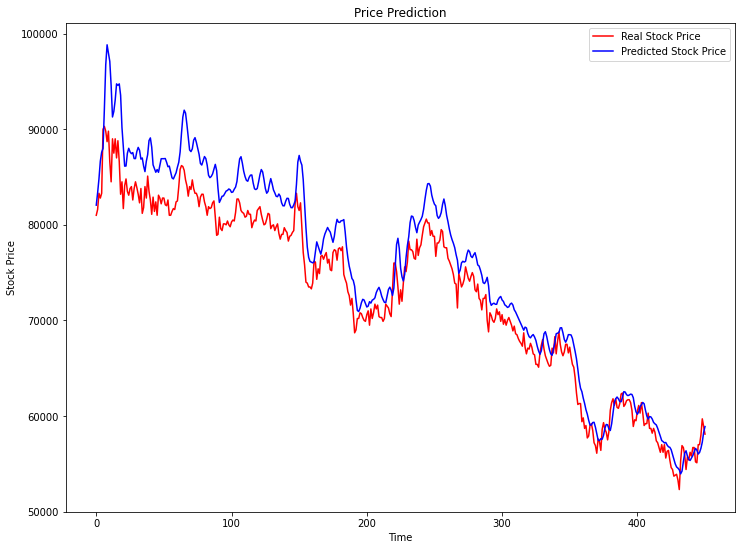

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
stock_price = np.append (predicted_stock_price, real_stock_price, axis=1)
stock_price[430:-1]

array([[54541.8828125 , 53300.        ],
       [54368.30859375, 52300.        ],
       [53942.20703125, 55300.        ],
       [54224.07421875, 56900.        ],
       [55207.125     , 56700.        ],
       [56106.99609375, 55900.        ],
       [56355.6640625 , 54400.        ],
       [55802.09375   , 55700.        ],
       [55452.92578125, 55400.        ],
       [55341.8828125 , 56200.        ],
       [55596.61328125, 55800.        ],
       [55854.80859375, 56700.        ],
       [56252.21875   , 56700.        ],
       [56610.58984375, 55200.        ],
       [56424.8046875 , 55100.        ],
       [56016.58203125, 57000.        ],
       [56184.58203125, 57000.        ],
       [56618.87890625, 58000.        ],
       [57262.72265625, 59700.        ],
       [58271.5546875 , 58900.        ]])

## **Part 4 - LSTM 모델 설계#2 및 학습 실행**

이번에는 Keras에서 제공하는 방법을 이용하여 모델을 설계하고 학습해보았다.

In [ ]:
Stock_data # 2016년이후 데이터

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,25200,25200,24100,24100,306939,-0.043651
2016-01-05,24040,24360,23720,24160,216002,0.002490
2016-01-06,24160,24160,23360,23500,366752,-0.027318
2016-01-07,23320,23660,23020,23260,282388,-0.010213
2016-01-08,23260,23720,23260,23420,257763,0.006879
...,...,...,...,...,...,...
2022-10-25,57000,58600,57000,57700,17405678,0.003478
2022-10-26,58000,59600,57700,59400,20824967,0.029463
2022-10-27,59700,60100,58900,59500,21756712,0.001684


In [ ]:
time_steps = input("Input time steps ?")

Input time steps ?60


In [ ]:
for_periods = input("Output time steps ?")

Output time steps ?2


In [ ]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data (날짜를 인덱스로 하는 주가 데이터)
    output:
      X_train, y_train: 2016년부터 2020년까지 데이터
      X_test: 2021년 이후 데이터
    time_steps: # input 데이터의 time steps
    for_periods: # output 데이터의 time steps
    '''
    # training and test set 만들기 
    ts_train = all_data[:'2020'].iloc[:,0:1].values 
    ts_test = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    # training data의 샘플과 time steps으로 원본 데이터 슬라이싱하기기  
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
        
    # Reshaping X_train for efficient modelling 3차원 텐서로 재구성
    # np.reshape(sample, time steps, features)로 만듬
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test (feature 시가(Open)만 선택 결합)
    inputs = pd.concat((all_data["Open"][:'2020'], all_data["Open"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

In [ ]:
X_train, y_train, X_test = ts_train_test(Stock_data,int(time_steps),int(for_periods)) # input함수로 입력된 값은 int()로 변환해주어야 함.

In [ ]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):

    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer = 'adam',loss='mean_squared_error')
    
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=150,batch_size=32, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

학습한 결과를 시각화해보고 실제 데이터와 비교해보자

In [ ]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Open', 'Prediction'])
    actual_pred['Open'] = Stock_data.loc['2021':,'Open'][0:len(preds)]
    actual_pred['Prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Open']), np.array(actual_pred['Prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

In [ ]:
my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]

15/15 [==============================] - 1s 6ms/step


array([[81356.914, 82266.68 ],
       [80383.86 , 81449.086],
       [83043.31 , 84116.15 ],
       [81055.03 , 82376.516],
       [82449.5  , 83857.766],
       [89179.516, 90422.15 ],
       [87451.62 , 88927.39 ],
       [88606.09 , 90261.39 ],
       [86008.67 , 87984.32 ]], dtype=float32)

In [ ]:
my_LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 71,102
Trainable params: 71,102
Non-trai

(3134272.5, <matplotlib.axes._subplots.AxesSubplot at 0x7f10ae081790>)

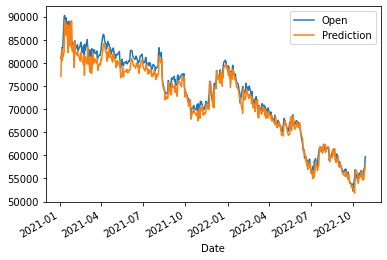

In [ ]:
actual_pred_plot(LSTM_prediction)  

**[EOD]**